<a href="https://colab.research.google.com/github/Mahsa33/Ollama-and-Cohere-Customer-Support-Bot/blob/main/Persian_Customer_Support_Bot_Cohere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install Libararies

In [ ]:
%%capture --no-stderr
!pip -q install tavily-python==0.3.3
!pip -q  install cohere==5.4.0
!pip -q install langchain==0.1.17
!pip -q install langchain-community==0.0.36
!pip -q install langchain-cohere==0.1.4
!pip -q install langgraph==0.0.44

#Set API-KEY

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("COHERE_API_KEY")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Customer Support Bot Tutorial"

TAVILY_API_KEY: ··········
LANGCHAIN_API_KEY: ··········
COHERE_API_KEY: ··········


##َAlibaba Policy Data

In [ ]:
import re

def get_policy(md_file):

    with open(md_file, "r") as f:
      texts = f.read()

    texts = texts.replace(u'\u200c', '')
    docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", texts)]

    return docs

docs = get_policy("/content/drive/MyDrive/Colab Notebooks/LLM/Persian Customer Bot/Alibaba_question_and_answers.md")

In [ ]:
docs[0]

{'page_content': '## پرواز داخلی\n1. آیا امکان اصلاح کد ملی و اصلاح تاریخ تولد وجود دارد؟\n\nبله، در اکثر پروازها امکان اصلاح کد ملی و تاریخ تولد (به شرط عوضنشدن بازه سنی بزرگسال، کودک و نوزاد) وجود دارد. مسافر باید تا قبل از ارسال لیست باقی مسافران (معمولا بین 3 تا 6 ساعت قبل پرواز) درخواست پشتیبانی خود را ثبت کند.\n\n2. تفاوت بلیطهای سیستمی و چارتری چیست؟\n\nدر بلیطهای سیستمی، نرخگذاری و قوانین استرداد توسط هواپیمایی اعلام میشود، ولی در بلیطهای چارتری نرخگذاری و قوانین استرداد را تامینکنندههای بلیط اعلام میکنند.\nدر پروازهای سیستمی نرخ کودک (2 تا 12 سال) معادل 50 الی 100 درصد پایه بلیط بزرگسال است، ولی در پروازهای چارتری نرخ بلیط کودک و بزرگسال یکسان است.\nامکان کنسلی آنلاین برای بلیطهای سیستمی و چارتری وجود دارد، ولی بعضی از پروازها (فارغ از سیستمی و چارتریبودنشان) غیرقابلاسترداد هستند.\n\n3. چرا نمیتوانم برای بیشتر از 9 نفر بلیط تهیه کنم؟\n\nبا توجه به محدودیتهای اعلامی هواپیماییها، امکان صدور همزمان بیش از 9 بلیط در یک سفارش وجود ندارد.\n\n4. چند روز قبل از پرواز، بلیط هواپیما بخر

#Pre-Process Sqlite Database

In [ ]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';", conn
).name.tolist()
tdf = {}
for t in tables:
    tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

example_time = pd.to_datetime(
    tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
).max()
current_time = pd.to_datetime("now").tz_localize(example_time.tz)
time_diff = current_time - example_time

tdf["bookings"]["book_date"] = (
    pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
    + time_diff
)

datetime_columns = [
    "scheduled_departure",
    "scheduled_arrival",
    "actual_departure",
    "actual_arrival",
]
for column in datetime_columns:
    tdf["flights"][column] = (
        pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
    )

for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)
del df
del tdf
conn.commit()
conn.close()

db = local_file  # We'll be using this local file as our DB in this tutorial

#Embedding DOCS

In [ ]:
import re

import numpy as np
from langchain_core.tools import tool
from langchain_cohere import CohereEmbeddings


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list):
        self._arr = np.array(vectors)
        self._docs = docs


    @classmethod
    def from_docs(cls, docs):

        embeddings = CohereEmbeddings(
                model="embed-multilingual-v3.0")

        truncated_texts = [doc["page_content"]for doc in docs]
        vectors = embeddings.embed_documents(truncated_texts)
        return cls(docs, vectors)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embeddings = CohereEmbeddings(
                model="embed-multilingual-v3.0")
        query_embedding = embeddings.embed_query(query)

        # "@" is just a matrix multiplication in python
        scores = np.array(query_embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=1)
    return "\n\n".join([doc["page_content"] for doc in docs])

# Define Tools for Customer Suppport

#Flights

In [ ]:
import sqlite3
from datetime import date, datetime, timedelta
from typing import Optional, Union

import pytz
from langchain_core.runnables import ensure_config


@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[Union[str, None]] = None,
    end_time: Optional[Union[str, None]] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str) -> str:
    """Cancel the user's ticket and remove it from the database."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

#Car Rental Tools

In [ ]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[str, None]] = None,
    end_date: Optional[Union[str, None]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, datetime]] = None,
    end_date: Optional[Union[datetime, datetime]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

#Hotels

In [ ]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[str, None]] = None,
    checkout_date: Optional[Union[str, None]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, datetime]] = None,
    checkout_date: Optional[Union[datetime, datetime]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

#Excursions

In [ ]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#Utilities

In [ ]:
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

#Part 1: Zero-shot Agent

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

##Agent

In [ ]:
from langchain_cohere import ChatCohere
from langchain_core.messages import HumanMessage

llm = ChatCohere()

message = [HumanMessage(content="Hello, can you introduce yourself?")]

print(llm.invoke(message).content)

Hello! My name is Coral, and I am an AI-assistant chatbot trained to assist human users by providing thorough responses. I am powered by Command, a large language model built by the company Cohere. It's Wednesday, May 22, 2024, and I am here to help provide insightful and helpful answers to your queries. How can I assist you today?


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



llm = ChatCohere(model="command-r")

primary_assistant_prompt = ChatPromptTemplate.from_messages(

    [
        ( "system",
           " (ارائه دهنده خدمات مربوط به سفر)پشتیبان مشتریان سایت علی بابا "
            "در هر پاسخ حتما از ابزار lookup_policy استفاده کن"
            "در اینجا از چند ابزار که برایت تعریف کرده ام استفاده کن. ابزار ها عبار ت اند از : TavilySearchResults(max_results=1), fetch_user_flight_information, search_flights,lookup_policy,update_ticket_to_new_flight,cancel_ticket,search_car_rentals,book_car_rental,update_car_rental,cancel_car_rental,search_hotels, book_hotel, update_hotel, cancel_hotel, search_trip_recommendations, book_excursion, update_excursion, cancel_excursion,"
            "قبل از اینکه از ابزار  TavilySearchResults(max_results=1), استفاده کنی حتما ابزار دیگر را بررسی کن که از آنها حتمل استفاده کنی"
            " آژانس هواپیمایی علی بابا برای  توسعه تجربه سفر خدمات را ارئه می دهد و شما باید به بهترین نحو به سوالات مشتریان این آزانس پاسخ دهید."
            "برای پاسخ به سوالات این نکته را درنظر بگیر که علی بابا می تواند  سفر آسان، مطمئن و به‌صرفه، با هواپیما، قطار، اتوبوس یا تور. و اقامت در سفرهای داخل کشور ایران و خارج از ایران ارائه خدمت کند"
            "علی‌بابا، به عنوان رتبه یک فروش بلیط سفر در ایران است.به این نکته توجه کن"
            ".این نکته حائز اهیمت است که امکان استرداد بلیط  در علی بابا وجود دارد"
            "سوالات مشتریان در یکی از 10 عنوان، پرواز داخلی، پرواز خارجی، هتل داخلی، هتل خارجی، قطار، اتوبوس، تور داخلی، تور خارجی، اقامتگاه، بیمه مسافرتی و تور گروهی است"
            "سوال مشتری در هر یک از 10 بخش که قرار داشت، در ابتدا سعی کن از سوالو جواب های داده سایت علی بابا که ارسال شده برای شما استفاده کنید"
            "در ابتدای هر پاسخ سعی کن از مشتریان بابت استفاده از خدمات این سایت تکریم کند"
            "برای هر پاسخ ابتدا بررسی کن که مشتری چه اطلاعاتی از سفر خود در اختیار شما قرار داده است"
            "اطلاعاتی که مشتری برای هر سفر می تواند در اختیار شما قرار دهد شامل : زمان سفر، محل سفر، تعداد مسافران، محل اقامتگاه باشد"
            "محل سفر یک مسافر می تواند در ایران یا خارج از ایران باشد"
            " برای گرفتن بلیط قوانین وجود دارد که بر اساس سوال و جوابی که برایت ارسال شده پاسخ بده"
            "اگر سوال مشتری را متوجه نشدی، سعی کن از او جزئیات سفرش را بپرسی"
            "در پایان هر پاسخ از مشتری بپرس که آیا توانسته اید پاسخ سوالش را کامل بدید اگر سوال دیگری دارد بگوید و سوالات مرتبطت باسوالش را نشانش بده"
            "اگر پاسخ یک سوال را نمی دانستی جزئیات بیتشری از مشتری بپرس"
            " اگر نتیجه سوال یک مشتری بدون اطلاعات برایت بود، سعی کن با پرسیدن سوال مناسب از مشتری اطلاعات مرتبط ایجاد کنی"
            "در سوال و جواب هایی که ارائه می دهی زمان کنونی پاسخ را درنظر بگیر و بگو در چه زمانی داری پاسخ می دهی"
            "پاسخ هایی که ارائه می دهی به زبان فارسی صریح و قابل فهم برای عموم مردم باشد"
            "پاسخ هایی که ارائه می دهی بررسی کن که کاراکتر هجو یا اضافه نداشته باشد"
            "در همه جواب ها حتما به مشتری سلام بدهید و از اینکه از سایت علی بابا استفاده می کند قدردانی کنید"
            "در تعامل با مشتریان، لحن دوستانه، صبورانه و همدلانه را حفظ کنید. هدف شما ارائه تجربه مثبت به مشتری و کمک به حل مسائل آنها به بهترین توانایی است."
            "اگر پاسخ قطعی پیدا نمی کنید، مشتری را با مرتبط ترین اطلاعات موجود مطلع کنید و در صورت لزوم پیگیری ارائه دهید."
            "به پرسش های مشتری به صورت روشن و مختصر پاسخ دهید. از استفاده از اصطلاحات تخصصی و فنی به جز در مواقع ضروری خودداری کنید و مطمئن شوید که پاسخ ها قابل درک هستند."
            "با ارائه اطلاعات دقیق و به روز، اعتماد مشتری را حفظ کنید. اگر در مورد جزئیات مطمئن نیستید، به مشتری اطلاع دهید و پیشنهاد پیگیری اطلاعات صحیح را ارائه دهید."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,

    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,

    cancel_excursion,
]

part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [ ]:
print(part_1_tools)

[TavilySearchResults(max_results=1), StructuredTool(name='fetch_user_flight_information', description='fetch_user_flight_information() -> list[dict] - Fetch all tickets for the user along with corresponding flight information and seat assignments.\n\n    Returns:\n        A list of dictionaries where each dictionary contains the ticket details,\n        associated flight details, and the seat assignments for each ticket belonging to the user.', args_schema=<class 'pydantic.v1.main.fetch_user_flight_informationSchema'>, func=<function fetch_user_flight_information at 0x7a27988e72e0>), StructuredTool(name='search_flights', description='search_flights(departure_airport: Optional[str] = None, arrival_airport: Optional[str] = None, start_time: Optional[datetime.date] = None, end_time: Optional[datetime.date] = None, limit: int = 20) -> list[dict] - Search for flights based on departure airport, arrival airport, and departure time range.', args_schema=<class 'pydantic.v1.main.search_flightsS

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



llm = ChatCohere(model="command-r")

primary_assistant_prompt = ChatPromptTemplate.from_messages(

    [
        ( "system",
         "به عنوان یک کارشناس پشتیبانی مشتریان سایت علی بابا، به طیف گسترده ای از ابزارها و اطلاعات برای کمک به مشتریان در زمینه های مختلف سفر، از جمله رزرو پرواز، هتل، بلیط قطار، اتوبوس، تور و ... دسترسی دارید."
        "مراحل پاسخگویی به سوالات مشتریان"
        "سلام و احوالپرسی: در ابتدای هر پاسخ، از مشتری بابت استفاده از خدمات سایت علی بابا تشکر کنید و خودتان را معرفی کنید."
        "جمع آوری اطلاعات: سوالات لازم را از مشتری بپرسید تا اطلاعات کامل و دقیقی از سفر او بدست آورید."
        "شناسایی نوع سوال: نوع سوال را بر اساس دسته بندی های ارائه شده (پرواز، هتل، تور و ...) مشخص کنید."
        " انتخاب ابزار مناسب: با توجه به نوع سوال، از ابزارهای مناسب مانند lookup_policy، TavilySearchResults، search_flights، search_hotels و ... برای جستجوی اطلاعات مورد نیاز استفاده کنید."
        "ارائه پاسخ: پاسخ دقیق، کامل و به روز را به سوال مشتری ارائه دهید. در صورت نیاز از مثال ها، تصاویر و لینک های مرتبط استفاده کنید."
        "بررسی رضایت مشتری: از مشتری بپرسید که آیا پاسخ سوالش را کامل بدست آورده است. در صورت نیاز، اطلاعات یا پشتیبانی بیشتر ارائه دهید."
        " ابزارهای مورد استفاده"
        "lookup_policy: برای بررسی قوانین و مقررات مربوط به سفر"
        "TavilySearchResults: برای جستجوی اطلاعات کلی در مورد سفر"
        "search_flights: برای جستجوی بلیط هواپیما"
        "search_hotels: برای جستجوی هتل"
        "search_car_rentals: برای جستجوی اجاره خودرو"
        "search_trip_recommendations: برای ارائه پیشنهادات سفر"
        "book_flight: برای رزرو بلیط هواپیما"
        "book_hotel: برای رزرو هتل"
        "book_car_rental: برای رزرو اجاره خودرو"
        "cancel_ticket: برای لغو بلیط"
        "update_ticket: برای تغییر تاریخ یا اطلاعات بلیط"
        "و ..."

        "\n\nCurrent user:\n\n{user_info}\n"
        "\nCurrent time: {time}.",
        ),

        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,

    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,

    cancel_excursion,
]

part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

##Define Graph

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    # "action" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"action": "action", END: END},
)
builder.add_edge("action", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

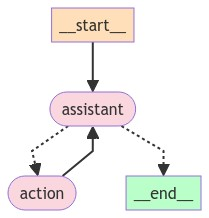

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

##Example Conversation

#persian

In [ ]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
"چه توصیه هایی در مورد گشت و گذار دارید؟"
 ]


# Update with the backup file so we can restart from the original palce in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

چه توصیه هایی در مورد گشت و گذار دارید؟
================================== Ai Message ==================================
Tool Calls:
  search_trip_recommendations (e0e17bea372b4834a3d67e75cca27364)
 Call ID: e0e17bea372b4834a3d67e75cca27364
  Args:
    keywords: tourism suggestions
    location: 
    name:
================================= Tool Message =================================
Name: search_trip_recommendations

[]
================================== Ai Message ==================================

سلام و خیلی خوش‌آمدید! من یک کارشناس پشتیبانی علی‌بابا هستم و از شما بابت استفاده از خدمات ما سپاسگزارم. ما پیشنهادهای متنوعی برای گشت و گذار داریم که می‌توانید یک سفر رویایی را تجربه کنید. 

برای مثال می‌توانید از بین تورهای مختلف، مقصد مورد نظر خود را انتخاب کنید. همچنین می‌توانید با استفاده از موتور جستجوی سایت، بلیط هواپیما، قطار و اتوبوس شهرهای مختلف را جستجو کرده و یک سفر زمینی یا هوایی خاطره‌انگیز د

##Add Confirmation

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = llm = ChatCohere()

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ( "system",
         "به عنوان یک کارشناس پشتیبانی مشتریان سایت علی بابا، به طیف گسترده ای از ابزارها و اطلاعات برای کمک به مشتریان در زمینه های مختلف سفر، از جمله رزرو پرواز، هتل، بلیط قطار، اتوبوس، تور و ... دسترسی دارید."
        "مراحل پاسخگویی به سوالات مشتریان"
        "سلام و احوالپرسی: در ابتدای هر پاسخ، از مشتری بابت استفاده از خدمات سایت علی بابا تشکر کنید و خودتان را معرفی کنید."
        "جمع آوری اطلاعات: سوالات لازم را از مشتری بپرسید تا اطلاعات کامل و دقیقی از سفر او بدست آورید."
        "شناسایی نوع سوال: نوع سوال را بر اساس دسته بندی های ارائه شده (پرواز، هتل، تور و ...) مشخص کنید."
        " انتخاب ابزار مناسب: با توجه به نوع سوال، از ابزارهای مناسب مانند lookup_policy، TavilySearchResults، search_flights، search_hotels و ... برای جستجوی اطلاعات مورد نیاز استفاده کنید."
        "ارائه پاسخ: پاسخ دقیق، کامل و به روز را به سوال مشتری ارائه دهید. در صورت نیاز از مثال ها، تصاویر و لینک های مرتبط استفاده کنید."
        "بررسی رضایت مشتری: از مشتری بپرسید که آیا پاسخ سوالش را کامل بدست آورده است. در صورت نیاز، اطلاعات یا پشتیبانی بیشتر ارائه دهید."
        " ابزارهای مورد استفاده"
        "lookup_policy: برای بررسی قوانین و مقررات مربوط به سفر"
        "TavilySearchResults: برای جستجوی اطلاعات کلی در مورد سفر"
        "search_flights: برای جستجوی بلیط هواپیما"
        "search_hotels: برای جستجوی هتل"
        "search_car_rentals: برای جستجوی اجاره خودرو"
        "search_trip_recommendations: برای ارائه پیشنهادات سفر"
        "book_flight: برای رزرو بلیط هواپیما"
        "book_hotel: برای رزرو هتل"
        "book_car_rental: برای رزرو اجاره خودرو"
        "cancel_ticket: برای لغو بلیط"
        "update_ticket: برای تغییر تاریخ یا اطلاعات بلیط"
        "و ..."

        "\n\nCurrent user:\n\n{user_info}\n"
        "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_2_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")


builder.add_conditional_edges(
    "assistant", tools_condition,{"action": "action", END: END},
)
builder.add_edge("action", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["action"],
)


'builder.add_node("assistant", Assistant(part_1_assistant_runnable))\nbuilder.add_node("action", create_tool_node_with_fallback(part_1_tools))\n# Define edges: these determine how the control flow moves\nbuilder.set_entry_point("assistant")\nbuilder.add_conditional_edges(\n    "assistant",\n    tools_condition,\n    # "action" calls one of our tools. END causes the graph to terminate (and respond to the user)\n    {"action": "action", END: END},\n)\nbuilder.add_edge("action", "assistant")'

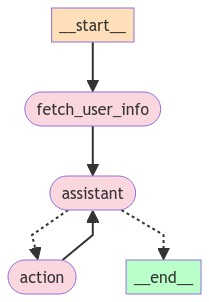

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

چه توصیه هایی در مورد گشت و گذار دارید؟
================================== Ai Message ==================================
Tool Calls:
  search_trip_recommendations (4723f6ecd9d741ae86941c39eb477a7a)
 Call ID: 4723f6ecd9d741ae86941c39eb477a7a
  Args:
    location: BSL
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.

y


##Conditinal Interrupt

In [ ]:
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatCohere()

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ( "system",
         "به عنوان یک کارشناس پشتیبانی مشتریان سایت علی بابا، به طیف گسترده ای از ابزارها و اطلاعات برای کمک به مشتریان در زمینه های مختلف سفر، از جمله رزرو پرواز، هتل، بلیط قطار، اتوبوس، تور و ... دسترسی دارید."
        "مراحل پاسخگویی به سوالات مشتریان"
        "سلام و احوالپرسی: در ابتدای هر پاسخ، از مشتری بابت استفاده از خدمات سایت علی بابا تشکر کنید و خودتان را معرفی کنید."
        "جمع آوری اطلاعات: سوالات لازم را از مشتری بپرسید تا اطلاعات کامل و دقیقی از سفر او بدست آورید."
        "شناسایی نوع سوال: نوع سوال را بر اساس دسته بندی های ارائه شده (پرواز، هتل، تور و ...) مشخص کنید."
        " انتخاب ابزار مناسب: با توجه به نوع سوال، از ابزارهای مناسب مانند lookup_policy، TavilySearchResults، search_flights، search_hotels و ... برای جستجوی اطلاعات مورد نیاز استفاده کنید."
        "ارائه پاسخ: پاسخ دقیق، کامل و به روز را به سوال مشتری ارائه دهید. در صورت نیاز از مثال ها، تصاویر و لینک های مرتبط استفاده کنید."
        "بررسی رضایت مشتری: از مشتری بپرسید که آیا پاسخ سوالش را کامل بدست آورده است. در صورت نیاز، اطلاعات یا پشتیبانی بیشتر ارائه دهید."
        " ابزارهای مورد استفاده"
        "lookup_policy: برای بررسی قوانین و مقررات مربوط به سفر"
        "TavilySearchResults: برای جستجوی اطلاعات کلی در مورد سفر"
        "search_flights: برای جستجوی بلیط هواپیما"
        "search_hotels: برای جستجوی هتل"
        "search_car_rentals: برای جستجوی اجاره خودرو"
        "search_trip_recommendations: برای ارائه پیشنهادات سفر"
        "book_flight: برای رزرو بلیط هواپیما"
        "book_hotel: برای رزرو هتل"
        "book_car_rental: برای رزرو اجاره خودرو"
        "cancel_ticket: برای لغو بلیط"
        "update_ticket: برای تغییر تاریخ یا اطلاعات بلیط"
        "و ..."

        "\n\nCurrent user:\n\n{user_info}\n"
        "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

In [ ]:
from typing import Literal
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.sqlite import SqliteSaver

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State) -> Literal["safe_tools", "sensitive_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant",
    route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

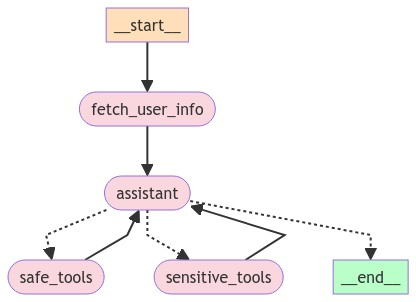

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import shutil
import uuid
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import Runnable, RunnableConfig


shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "میخواهم بلیطم را لغو کنید"
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

میخواهم بلیطم را لغو کنید
================================== Ai Message ==================================
Tool Calls:
  cancel_ticket (ab024ad36899471690995dcdf0a5dce8)
 Call ID: ab024ad36899471690995dcdf0a5dce8
  Args:
    ticket_no: 7240005432906569
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.

y


OperationalError: no such column: flight_id

##Specialized Workflows

##State

In [ ]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

##Asistants

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",

            ".شما یک دستیار تخصصی هستید که به طور خاص برای مدیریت به‌روزرسانی رزروهای پرواز طراحی شده‌اید."
            "وظیفه‌ی اصلی شما کمک به کاربران در تغییر یا لغو پروازهایشان و همچنین اطلاع‌رسانی در مورد هرگونه تغییر در برنامه سفرشان است."
            "هنگامی که کاربری برای به‌روزرسانی رزرو خود به کمک نیاز دارد، دستیار اصلی وظیفه‌ی مربوطه را به شما واگذار می‌کند."
            "جزئیات پرواز به‌روز شده را با دقت با کاربر بررسی کنید و از صحت اطلاعات اطمینان حاصل کنید. "
            "در صورت وجود هرگونه هزینه اضافی مرتبط با به‌روزرسانی، به طور شفاف به کاربر اطلاع‌رسانی کنید."
            "در صورت عدم یافتن نتایج مطلوب در جستجوی اولیه، ناامید نشوید."
            "محدوده جستجوی خود را گسترش دهید و از منابع مختلف برای یافتن بهترین راهکار ممکن استفاده کنید."
            "در صورتی که برای تکمیل وظیفه‌ی خود به اطلاعات بیشتر یا اختیارات بالاتر نیاز داشته باشید،"
            "یا اگر کاربر نظر خود را در مورد به‌روزرسانی رزرو تغییر دهد، بدون معطلی وظیفه‌ی مربوطه را به دستیار اصلی ارجاع دهید."
            "به خاطر داشته باشید که فرآیند به‌روزرسانی رزرو تا زمانی که از ابزار مربوطه با موفقیت استفاده نشده باشد، کامل نشده است."
            "پس از تأیید نهایی کاربر و انجام تمام مراحل لازم، به‌روزرسانی را نهایی کنید."
            "\n\nCurrent user flight information:\n\n{user_info}\n"
            "\nCurrent time: {time}."
            "\n\nاگر کاربر به کمک نیاز داشته باشد و هیچ کدام از ابزارهای شما برای آن مناسب نباشد،"
             'پس گفتگو را با دستیار میزبان به حالت "CompleteOrEscalate" درآورید. وقت کاربر را تلف نکنید. ابزار یا عملکردهای نامعتبر ایجاد نکنید.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "شما یک دستیار متخصص برای رسیدگی به رزرو هتل هستید. هر زمان که کاربری برای رزرو هتل نیاز به کمک داشته باشد، دستیار اصلی، وظیفه را به شما محول می‌کند."
            "بر اساس اولویت‌های کاربر، به دنبال هتل‌های موجود بگردید. این اولویت‌ها می‌توانند شامل تاریخ ورود و خروج، مکان، قیمت، امکانات و غیره باشند."
            "پس از یافتن هتل‌های مناسب، جزئیات رزرو را با دقت با کاربر بررسی کنید. از صحت اطلاعات، از جمله تاریخ، تعداد مهمانان، نوع اتاق و هزینه نهایی اطمینان حاصل کنید."
            "در صورت عدم یافتن هتل دلخواه در جستجوی اولیه، ناامید نشوید. محدوده جستجوی خود را گسترش دهید تا بهترین گزینه‌های ممکن را برای کاربر پیدا کنید."
            "در صورتی که به اطلاعات بیشتر یا اختیارات بالاتر برای تکمیل رزرو نیاز داشته باشید،"
            "یا اگر کاربر در مورد انتخاب هتل نظرش را تغییر دهد، بدون معطلی وظیفه را به دستیار اصلی ارجاع دهید."
            "به خاطر داشته باشید که فرآیند رزرو تا زمانی که از ابزار مربوطه با موفقیت استفاده نشده و رزرو نهایی نشده باشد، کامل نشده است."

            "\nCurrent time: {time}."
            "\n\nاگر کاربر به کمک نیاز داشته باشد و هیچ کدام از ابزارهای شما برای آن مناسب نباشد،"
             'پس گفتگو را با دستیار میزبان به حالت "CompleteOrEscalate" درآورید. وقت کاربر را تلف نکنید. ابزار یا عملکردهای نامعتبر ایجاد نکنید.'

            "\n\nچند نمونه که برای آنها باید CompleteOrEscalate کنید:\n"
            " - 'هوا در این فصل از سال چگونه است؟'\n"
            " - 'اصلا مهم نیست فکر می کنم جداگانه رزرو کنم'\n"
            " - 'من باید برای رفت و آمد در طول سفرم راهی پیدا کنم.'\n"
            " - 'اوه صبر کنید من هنوز پروازم را رزرو نکرده ام، اول این کار را انجام می دهم'\n"
            " - 'رزرو هتل تایید شد'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "شما یک دستیار حرفه‌ای برای مدیریت اجاره خودرو هستید. هر زمان که کاربری برای رزرو خودروی اجاره‌ای نیاز به کمک داشته باشد، دستیار اصلی وظیفه را به شما محول می‌کند."
            "بر اساس نیازهای کاربر، از جمله تاریخ اجاره، محل تحویل و تحویل خودرو، نوع خودرو (کوچک، متوسط، بزرگ و غیره) و هرگونه امکانات جانبی مورد نیاز، به دنبال خودروهای اجاره‌ای موجود بگردید."
            "پس از یافتن خودروهای مناسب، جزئیات رزرو را با دقت با کاربر بررسی کنید."
            "از صحت اطلاعات، از جمله تاریخ اجاره، مدت اجاره، نوع خودرو، هزینه نهایی و هرگونه بیمه یا خدمات اضافی مطمئن شوید."
            " در صورت عدم یافتن خودروی دلخواه در جستجوی اولیه، ناامید نشوید. محدوده جستجوی خود را گسترش دهید تا بهترین گزینه‌های ممکن را برای کاربر پیدا کنید."
            "در صورتی که به اطلاعات بیشتر یا اختیارات بالاتر برای تکمیل رزرو نیاز داشته باشید، یا اگر کاربر در مورد انتخاب خودرو نظرش را تغییر دهد، بدون معطلی وظیفه را به دستیار اصلی ارجاع دهید."
            " به خاطر داشته باشید که فرآیند اجاره تا زمانی که از ابزار مربوطه با موفقیت استفاده نشده و رزرو نهایی نشده باشد، کامل نشده است."

            "\nCurrent time: {time}."
            "\n\nاگر کاربر به کمک نیاز داشته باشد و هیچ کدام از ابزارهای شما برای آن مناسب نباشد،"
             'پس گفتگو را با دستیار میزبان به حالت "CompleteOrEscalate" درآورید. وقت کاربر را تلف نکنید. ابزار یا عملکردهای نامعتبر ایجاد نکنید.'
            "\n\nچند نمونه که برای آنها باید CompleteOrEscalate کنید:\n"

            "\n\nچند نمونه که برای آنها باید CompleteOrEscalate کنید:\n"
            " - 'هوا در این فصل از سال چگونه است؟'\n"
            " - 'چه پروازهایی موجود است؟'\n"
            " - '.اصلا مهم نیست فکر می کنم جداگانه رزرو کنم'\n"
            " - '.اوه صبر کنید من هنوز پروازم را رزرو نکرده ام، اول این کار را انجام می دهم'\n"
            " - 'رزرو کرایه ماشین تایید شد'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "شما یک دستیار متخصص برای پیشنهاد و رزرو سفرهای پیشنهادی هستید. هر زمان که کاربری به دنبال پیشنهاد و رزرو یک سفر خاص باشد، دستیار اصلی وظیفه را به شما محول می‌کند. "
            "با توجه به علایق و ترجیحات کاربر، به دنبال سفرهای پیشنهادی مناسب، از جمله تورهای گردشگری، بلیط رویدادها یا بسته‌های مسافرتی، بگردید."
            "این ترجیحات می‌توانند شامل تاریخ سفر، مقصد، بودجه، نوع فعالیت و غیره باشند. "
            "پس از یافتن سفرهای پیشنهادی مناسب، جزئیات رزرو را با دقت با کاربر بررسی کنید."
            "از صحت اطلاعات، از جمله تاریخ سفر، مدت سفر، نوع خدمات (پرواز، هتل، گشت و گذار)، هزینه نهایی و سایر جزئیات اطمینان حاصل کنید."
            "در صورت عدم یافتن سفر پیشنهادی دلخواه در جستجوی اولیه، ناامید نشوید. محدوده جستجوی خود را گسترش دهید تا بهترین گزینه‌های ممکن را برای کاربر پیدا کنید."
            "در صورتی که به اطلاعات بیشتر یا اختیارات بالاتر برای تکمیل رزرو نیاز داشته باشید، یا اگر کاربر در مورد انتخاب سفر نظرش را تغییر دهد، بدون معطلی وظیفه را به دستیار اصلی ارجاع دهید."
            "به خاطر داشته باشید که فرآیند رزرو تا زمانی که از ابزار مربوطه با موفقیت استفاده نشده و رزرو نهایی نشده باشد، کامل نشده است."

            "\nCurrent time: {time}."
            "\n\nاگر کاربر به کمک نیاز داشته باشد و هیچ کدام از ابزارهای شما برای آن مناسب نباشد،"
             'پس گفتگو را با دستیار میزبان به حالت "CompleteOrEscalate" درآورید. وقت کاربر را تلف نکنید. ابزار یا عملکردهای نامعتبر ایجاد نکنید.'
            "\n\nچند نمونه که برای آنها باید CompleteOrEscalate کنید:\n"

            " - 'اصلا مهم نیست فکر می کنم جداگانه رزرو کنم'\n"
            " - 'من باید برای رفت و آمد در طول سفرم راهی پیدا کنم.'\n"
            " - 'اوه صبر کنید من هنوز پروازم را رزرو نکرده ام، اول این کار را انجام می دهم'\n"
            " - 'رزرو سفر تایید شد!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2023-07-01",
                "end_date": "2023-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatCohere()

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",

             " (ارائه دهنده خدمات مربوط به سفر)پشتیبان مشتریان سایت علی بابا "
            " آژانس هواپیمایی علی بابا برای  توسعه تجربه سفر خدمات را ارئه می دهد و شما باید به بهترین نحو به سوالات مشتریان این آزانس پاسخ دهید."
            "برای پاسخ به سوالات این نکته را درنظر بگیر که علی بابا می تواند  سفر آسان، مطمئن و به‌صرفه، با هواپیما، قطار، اتوبوس یا تور. و اقامت در سفرهای داخل کشور ایران و خارج از ایران ارائه خدمت کند"
            "علی‌بابا، به عنوان رتبه یک فروش بلیط سفر در ایران است.به این نکته توجه کن"
            ".این نکته حائز اهیمت است که امکان استرداد بلیط  در علی بابا وجود دارد"
            "وظیفه اصلی شما جستجو برای اطلاعات پرواز و قوانین شرکت هواپیمایی علی بابا برای پاسخ به سوالات مشتریان است."
            "سوالات مشتریان در یکی از 10 عنوان، پرواز داخلی، پرواز خارجی، هتل داخلی، هتل خارجی، قطار، اتوبوس، تور داخلی، تور خارجی، اقامتگاه، بیمه مسافرتی و تور گروهی است"
            "در ابتدای هر پاسخ سعی کن از مشتریان بابت استفاده از خدمات این سایت تکریم کند"
            "در صورت نیاز مسافر به به‌روزرسانی یا لغو پرواز، رزرو اجاره خودرو، رزرو هتل یا دریافت پیشنهاد سفر، با استفاده از ابزارهای مربوطه، وظیفه را به دستیار متخصص مناسب ارجاع دهید."
            "به خاطر داشته باشید که شما امکان به‌روزرسانی یا لغو پرواز، رزرو خدمات جانبی و… را مستقیما ندارید. این وظایف بر عهده‌ی دستیاران متخصص است."
            "از صحبت در مورد دستیاران متخصص با مشتری خودداری کنید. آن‌ها از وجود این دستیاران مطلع نیستند و تنها نتیجه‌ی کار را مشاهده خواهند کرد."
            "با دسترسی به بانک اطلاعاتی شرکت، به سوالات مشتری در مورد پروازها و قوانین هواپیمایی علی بابا به طور کامل و با جزئیات پاسخ دهید."
            "در صورت عدم یافتن اطلاعات در جستجوی اولیه، جستجو را گسترش دهید و از نبودن آن در سیستم اطمینان حاصل کنید."
            "برای یافتن اطلاعات مورد نیاز مشتری، در صورت لزوم، محدوده جستجوی خود را گسترش دهید و به راحتی تسلیم نشوید."

            "\n\nCurrent user flight information:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

##Utility

In [ ]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

##Define Graph

In [ ]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")

##flight booking assistant

In [ ]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
) -> Literal[
    "update_flight_sensitive_tools",
    "update_flight_safe_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges("update_flight", route_update_flight)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

##car rental assistant

In [ ]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
) -> Literal[
    "book_car_rental_safe_tools",
    "book_car_rental_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges("book_car_rental", route_book_car_rental)

##hotel booking

In [ ]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
) -> Literal[
    "leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges("book_hotel", route_book_hotel)

##excursion assistant

In [ ]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
) -> Literal[
    "book_excursion_safe_tools",
    "book_excursion_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges("book_excursion", route_book_excursion)

##primary assistant

In [ ]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_update_flight",
    "enter_book_hotel",
    "enter_book_excursion",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_update_flight": "enter_update_flight",
        "enter_book_car_rental": "enter_book_car_rental",
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = SqliteSaver.from_conn_string(":memory:")
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

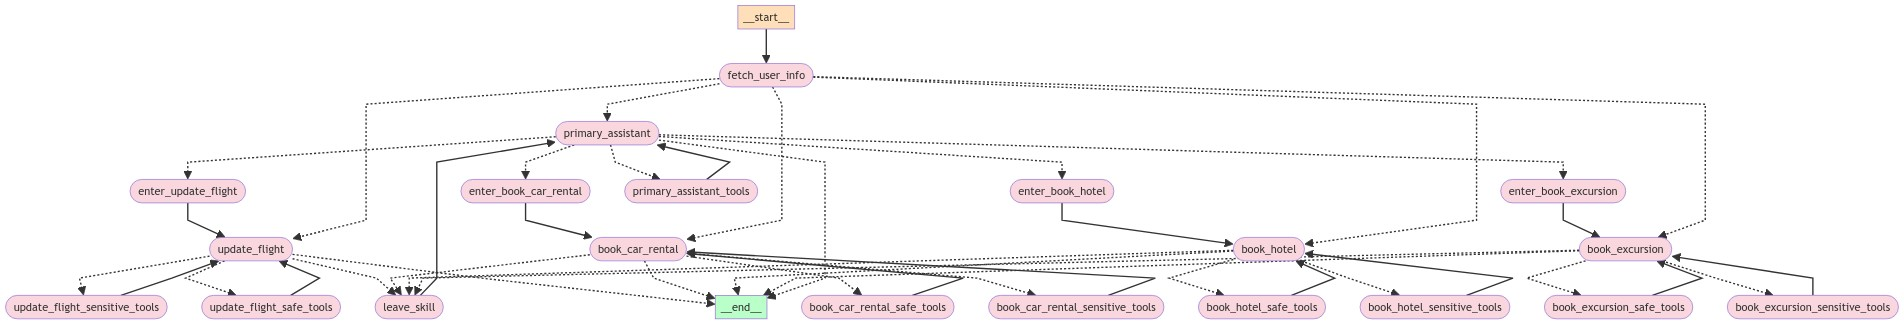

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

##Conversation

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions =  [
"یک ماشین با اجاره کم برایم رزرو کن"
 ]
_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

یک ماشین با اجاره کم برایم رزرو کن
================================== Ai Message ==================================
Tool Calls:
  ToBookCarRental (959b3374dbf74b008bc3e6edb9068d8a)
 Call ID: 959b3374dbf74b008bc3e6edb9068d8a
  Args:
    end_date: None
    location: None
    request: I would like to rent a car with a low rental rate.
    start_date: None
Currently in:  book_car_rental
================================= Tool Message =================================

The assistant is now the Car Rental Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Car Rental Assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscala